# Exploring Star Clusters in the Euclid ERO Data


## Learning Goals
By the end of this tutorial, you will be able to:

 &bull; Access the Euclid ERO images using `astroquery`

 &bull; Create cutouts on the large Euclid ERO images directly

 &bull; Extract sources on the Euclid image and run photometry tools

 &bull; Compare photometry to the Gaia catalog

 &bull; Visualize the Euclid ERO image and the Gaia catalog in `Firefly`


## Introduction
Euclid is a European Space Agency (ESA) space mission with NASA participation, to study the geometry and nature of the dark Universe. As part of its first observations, Euclid publicly released so-called *Early Release Observations* (ERO) targeting some press-worthy targets on the sky such as star clusters or local galaxies.

In this notebook, we will focus on the ERO data of **NGC 6397**, a globular cluster 78,000 light years away. (Note that there is another globular cluster, **NGC 6254** that can also be used for this analysis - in fact the user can choose which one to use) The goal of this analysis is to extract the Euclid photometry of the stars belonging to the cluster and compare them to the photometry of Gaia. Due to the different pixel scales of the visible (VIS, $0.1^{\prime\prime}$) and near-IR (NISP, $0.3^{\prime\prime}$) wavelengths, we will first detect and extract the stars in the VIS filter and use their position to subsequently extract the photometry in the NISP (Y, J, H) filters (a method also referred to as *forced photometry*).

One challenge with Euclid data is their size due to the large sky coverage and small pixel size.
This notebook demonstrates how to download only a cutout of the large Euclid ERO observation image (namely focussing only on the position of the globular cluster. Furthermore, this notebook demonstrates how to extract sources on a large astronomical image and how to measure their photometry across different pixel scales using a very simple implementation of the forced photometry method with positional priors.
Finally, we also demonstrate how to visualize the Euclid images and catalog in `Firefly`, an open-source web-based UI library for astronomical data archive access and visualization developed at Caltech (https://github.com/Caltech-IPAC/firefly). `Firefly` is a convenient tool to visualize images similar to DS9 on your local computer, but it can run on a cloud-based science platform.


This notebook is written to be used in Fornax which is a cloud based computing platform using AWS. The advantage of this is that the user does not need to download actuall data, hence the analysis of large datasets is not limited by local computing resources. It also allows to access data across all archives fast and easy.


## Data Volume
The total data volume required for running this notebook is less than 20 MB.

## Imports

First, we import all necessary packages.

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install tqdm numpy matplotlib astropy photutils astroquery>=0.4.10 sep>=1.4 firefly_client>=3.2

In [2]:
# General imports
import os
import numpy as np
from tqdm import tqdm

# Astroquery
from astroquery.ipac.irsa import Irsa
from astroquery.gaia import Gaia

# Astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

# Photometry tools
import sep
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, CircularGaussianSigmaPRF, make_psf_model_image
from photutils.background import LocalBackground, MMMBackground

# Firefly
from firefly_client import FireflyClient

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

/home/runner/work/irsa-tutorials/irsa-tutorials/.tox/py311-buildhtml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we define some parameters for `Matplotlib` plotting.

In [3]:
## Plotting stuff
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelpad'] = 7
mpl.rcParams['xtick.major.pad'] = 7
mpl.rcParams['ytick.major.pad'] = 7
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['ytick.minor.left'] = True
mpl.rcParams['ytick.minor.right'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['hatch.linewidth'] = 1

def_cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Setting up the Environment

Next, we set up the environment. This includes
* setting up an output data directory (will be created if it does not exist)
* define the search radius around the target of interest to pull data from the Gaia catalog
* define the cutout size that will be used to download a certain part of the Euclid ERO images

Finally, we also define the target of interest here. We can choose between two globular clusters, **NGC 6254** and **NGC6397**, both covered by the Euclid ERO data.

Note that `astropy` units can be attached to the `search_radius` and `cutout_size`.

In [4]:
# create output directory
if os.path.exists("./data/"):
    print("Output directory already created.")
else:
    print("Creating data directory.")
    os.mkdir("./data/")

search_radius = 1.5 * u.arcmin # search radius
cutout_size = 1.5 * u.arcmin # cutout size

coord = SkyCoord.from_name('NGC 6397')

Creating data directory.


## Search Euclid ERO Images

Now, we search for the Euclid ERO images using the `astroquery` package.
Note that the Euclid ERO images are no in the cloud currently, but we access them directly from IRSA using IRSA's *Simple Image Access* (SIA) methods.

```{note}
The following only works for combined images (either extended or point source stacks). This would not work if there are multiple, let's say, H-band images of Euclid at a given position. Therefore, no time domain studies here (which is anyway not one of the main goals of Euclid).
```

The IRSA SIA products can be listed via
```
Irsa.list_collections(servicetype='SIA')
```

Here we use the collection *euclid_ero*, containing the Euclid ERO images. We first create a `SkyCoord` object and then query the SIA.

In [5]:
image_tab = Irsa.query_sia(pos=(coord, search_radius), collection='euclid_ero')
print("Number of images available: {}".format(len(image_tab)))

Number of images available: 25


Sort the queried table by wavelength (column `em_min`). This allows us later when we plot the images to keep them sorted by wavelength (VIS, Y, J, H).

In [6]:
image_tab.sort('em_min')

Let's inspec the table that was downloaded.

In [7]:
image_tab[0:3]

<Table length=3>
    s_ra       s_dec    facility_name ... cloud_access o_ucd  upload_row_id
    deg         deg                   ...                                  
  float64     float64       object    ...    object    object     int64    
----------- ----------- ------------- ... ------------ ------ -------------
265.1744234 -53.6588139        Euclid ...           {}                    1
265.1744234 -53.6588139        Euclid ...           {}                    1
265.1744234 -53.6588139        Euclid ...           {}                    1

Next, we add additional restrictions to narrow down the images.

The Euclid ERO images come in two different flavors:
* *Flattened* images: idealized for compact sources (for example stars)
* *LSB* images: idealized for low surface brightness objects (for example galaxies)

Maybe counter-intuitively, we select the *LSB* images here by checking if the file name given in the URL (`access_url` column) contains that key word. We found that the *Flattened* images contain many masked pixels.

In [8]:
#sel_basic = np.where( ["Flattened" in tt["access_url"] for tt in image_tab] )[0]
sel_basic = np.where( ["LSB" in tt["access_url"] for tt in image_tab] )[0]
image_tab = image_tab[sel_basic]

Next, we want to check what filteres are available. This can be done by `np.unique()`, however, in that case it would sort the filters alphabetically. We want to keep the sorting based on the wavelength, therefore we opt for a more complicated way.

In [9]:
idxs = np.unique(image_tab["energy_bandpassname"], return_index=True)[1]
filters = [image_tab["energy_bandpassname"][idx] for idx in sorted(idxs)]
print("Filters: {}".format(filters))

Filters: ['VIS', 'Y', 'J', 'H']


We can now loop throught the filters and collect the images to create a handy summary table with all the data we have. This way we will have an easier time to later access the data.

In [10]:
# Create a dictionary with all the necessary information (science, weight, noise, mask)
summary_table = Table(names=["filter","products","facility_name","instrument_name"] , dtype=[str,str,str,str])
for filt in filters:
    sel = np.where(image_tab['energy_bandpassname'] == filt)[0]
    products = list( np.unique(image_tab["dataproduct_subtype"][sel].value) )
    if "science" in products: # sort so that science is the first in the list. This is the order we create the hdu extensions
        products.remove("science")
        products.insert(0,"science")
    else:
        print("WARNING: no science image found!")
    print(products)

    summary_table.add_row( [filt , ";".join(products), str(np.unique(image_tab["facility_name"][sel].value)[0]), str(np.unique(image_tab["instrument_name"][sel].value)[0])] )

['science', 'auxiliary']
['science', 'auxiliary']
['science', 'auxiliary']
['science', 'auxiliary']


Let's check out the summary table that we have created. We see that we have all the 4 Euclid bands and what data products are available for each of them.

In [11]:
summary_table

<Table length=4>
filter      products     facility_name instrument_name
 str3        str17            str6           str4     
------ ----------------- ------------- ---------------
   VIS science;auxiliary        Euclid             VIS
     Y science;auxiliary        Euclid            NISP
     J science;auxiliary        Euclid            NISP
     H science;auxiliary        Euclid            NISP

## Create Cutout Images

Now that we have a list of data products, we can create the cutouts. This is important as the full Euclid ERO images would be too large to run extraction and photometry software on them (they would simply fail due to memory issues).

For each image, we create a cutout around the target of interest, using the `cutout_size` defined above. The cutouts are then collected into HDUs. That way we can easily access the different data products. Note that we only use the *science* products as the *ancillary* products are not needed.

We save the HDU to disk as it will be later used when we visualize the Euclid ERO FITS images in `Firefly`.

```{note}
You will notice that `Cutout2D` can be applied to an URL. That way, it we do not need to download the full image to create a cutout. This is a useful trick to keep in mind when analyzing large images. This makes creating cutout images very fast.
```

In [12]:
%%time
for ii,filt in tqdm(enumerate(filters)):
    products = summary_table[summary_table["filter"] == filt]["products"][0].split(";")

    for product in products:
        sel = np.where( (image_tab["energy_bandpassname"] == filt) & (image_tab["dataproduct_subtype"] == product) )[0]

        with fits.open(image_tab['access_url'][sel[0]], use_fsspec=True) as hdul:
            tmp = Cutout2D(hdul[0].section, position=coord, size=cutout_size, wcs=WCS(hdul[0].header)) # create cutout


            if (product == "science") & (ii == 0): # if science image, then create a new hdu.
                hdu0 = fits.PrimaryHDU(data = tmp.data, header=hdul[0].header)
                hdu0.header.update(tmp.wcs.to_header()) # update header with WCS info
                hdu0.header["EXTNAME"] = "{}_{}".format(filt,product.upper())
                hdu0.header["PRODUCT"] = product.upper()
                hdu0.header["FILTER"] = filt.upper()
                hdulcutout = fits.HDUList([hdu0])
            elif (product == "science") & (ii > 0):
                hdu = fits.ImageHDU(data = tmp.data, header=hdul[0].header)
                hdu.header.update(tmp.wcs.to_header()) # update header with WCS info
                hdu.header["EXTNAME"] = "{}_{}".format(filt,product.upper())
                hdu.header["PRODUCT"] = product.upper()
                hdu.header["FILTER"] = filt.upper()
                hdulcutout.append(hdu)

## Save the HDUL cube:
hdulcutout.writeto("./data/euclid_images_test.fits", overwrite=True)

0it [00:00, ?it/s]
1it [00:18, 18.44s/it]
2it [00:21,  9.37s/it]
3it [00:28,  8.16s/it]
4it [00:59, 17.17s/it]
4it [00:59, 14.79s/it]


1it [00:18, 18.44s/it]

2it [00:21,  9.37s/it]

3it [00:28,  8.16s/it]

4it [00:59, 17.17s/it]

4it [00:59, 14.79s/it]

CPU times: user 1.62 s, sys: 352 ms, total: 1.97 s
Wall time: 59.2 s


Let's look at the HDU that we created to check what information we have. You see that all filters are collected in different extensions. Also note the different dimensions of the FITS layers as the pixel scale of VIS and NISP are different.

In [13]:
hdulcutout.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  VIS_SCIENCE    1 PrimaryHDU     190   (900, 900)   float32   
  1  Y_SCIENCE     1 ImageHDU       191   (300, 300)   float32   
  2  J_SCIENCE     1 ImageHDU       191   (300, 300)   float32   
  3  H_SCIENCE     1 ImageHDU       191   (300, 300)   float32


We can now plot the image cutouts that we generated. The globular cluster is clearly visible.

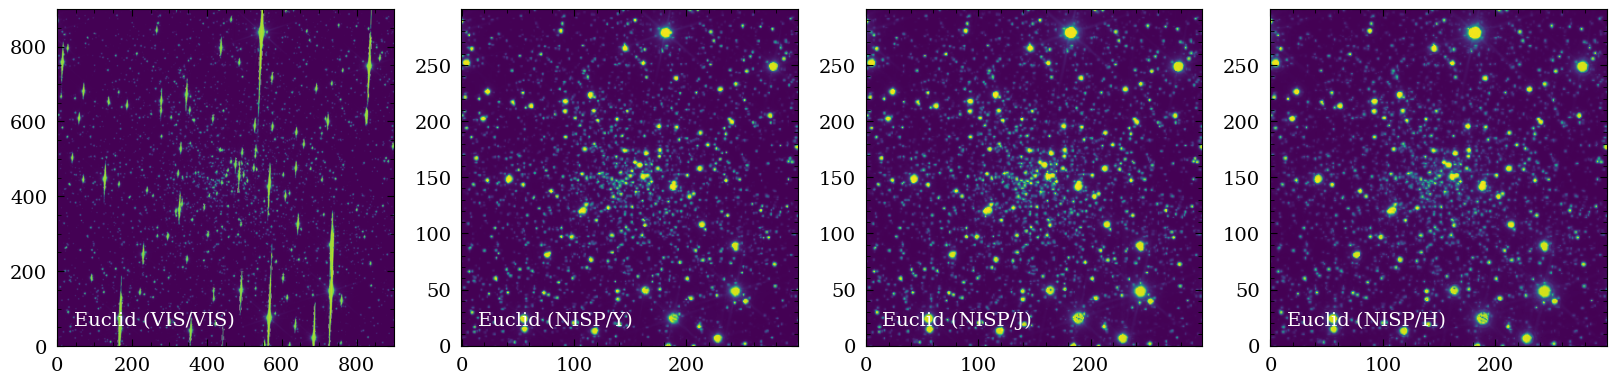

In [14]:
nimages = len(filters) # number of images
ncols = int(4) # number of columns
nrows = int( nimages // ncols ) # number of rows

fig = plt.figure(figsize = (5*ncols,5*nrows) )
axs = [fig.add_subplot(nrows,ncols,ii+1) for ii in range(nimages)]

for ii,filt in enumerate(filters):
    img = hdulcutout["{}_SCIENCE".format(filt)].data
    axs[ii].imshow(img , origin="lower")
    axs[ii].text(0.05,0.05 , "{} ({}/{})".format(summary_table["facility_name"][ii],summary_table["instrument_name"][ii],filt) , fontsize=14 , color="white",
                 va="bottom", ha="left" , transform=axs[ii].transAxes)

plt.show()

## Extract Sources and Measure their Photometry on the VIS Image

Now that we have the images in memory (and on disk - but we do not need them, yet), we can measure the fluxes of the individual stars.
Our simple photometry pipeline has different parts:

* First, we are using the Python package `sep` (similar to SExtractor) to extract the position of the sources. We do that on the VIS image, which provides the highest resolution.
* Second, we use `sep` to perform aperture measurements of the photometry. We will use that to compare the obtained fluxes to our forced photometry method
* Third, we apply a PSF fitting technique (using the `photutils` Python package) to improve the photometry measurement

We start by extracting the sources using `sep`. We first isolate the data that we want to look at (the VIS image only).

In [15]:
## Get Data (this will be replaced later)
img = hdulcutout["VIS_SCIENCE"].data
hdr = hdulcutout["VIS_SCIENCE"].header
img[img == 0] = np.nan

There are some NaN value on the image that we need to mask out. For this we create a mask image that we later feed to `sep`.

In [16]:
mask = np.isnan(img)

Next, we compute the background statistics what will be used by `sep` to extract the sources above a certain threshold.

In [17]:
mean, median, std = sigma_clipped_stats(img, sigma=3.0)
print(np.array((mean, median, std)))

[135.95872  99.62191 100.63356]


Finally, we perform object detection with `sep`. There are also modules in `photutils` to do that, however, we found that `sep` works best here. We output the number of objects found on the image.

In [18]:
objects = sep.extract(img-median, thresh=1.2, err=std, minarea=3, mask=mask, deblend_cont=0.0002, deblend_nthresh=64 )
print("Number of sources extracted: ", len(objects))

Number of sources extracted:  2759


Next, we perform simple aperture photometry on the detected sources. Again, we use the `sep` package for this. We will use these aperture photometry later to compare to the PSF photometry.

In [19]:
flux, fluxerr, flag = sep.sum_circle(img-median, objects['x'], objects['y'],r=3.0, err=std, gain=1.0)

Now, we use the `photutils` Python package to perform PSF fitting. Here we assume a simple Gaussian with a FWHM given by `psf_fwhm` as PSF.

```{note}
We use a Gaussian PSF here for simplicity. The photometry can be improved by using a pixelated PSF measured directly from the Euclid images (for example by stacking stars).
```

In [20]:
psf_fwhm = 0.16 # PSF FWHM in arcsec
pixscale = 0.1 # VIS pixel scale in arcsec/px

init_params = Table([objects["x"],objects["y"]] , names=["x","y"]) # initial positions
psf_model = CircularGaussianSigmaPRF(flux=1, sigma=psf_fwhm/pixscale / 2.35)
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
psf_model.sigma.fixed = False
fit_shape = (5, 5)
psfphot = PSFPhotometry(psf_model,
                        fit_shape,
                        finder = DAOStarFinder(fwhm=0.1, threshold=3.*std, exclude_border=True), # not needed because we are using fixed initial positions.
                        aperture_radius = 4,
                        progress_bar = True)


After initiating the `PSFPhotometry` object, we can run the PSF photometry measurement. This can take a while (typically between 1 and 2 minutes).

In [21]:
phot = psfphot(img-median, error=None, mask=mask, init_params=init_params)

Fit source/group: 100%|██████████| 2759/2759 [00:12<00:00, 216.73it/s]


Fit source/group:   1%|          | 26/2759 [00:00<00:10, 251.27it/s]

Fit source/group:   2%|▏         | 52/2759 [00:00<00:11, 242.54it/s]

Fit source/group:   3%|▎         | 78/2759 [00:00<00:10, 245.86it/s]

Fit source/group:   4%|▍         | 104/2759 [00:00<00:10, 250.25it/s]

Fit source/group:   5%|▍         | 131/2759 [00:00<00:10, 254.64it/s]

Fit source/group:   6%|▌         | 157/2759 [00:00<00:10, 246.81it/s]

Fit source/group:   7%|▋         | 182/2759 [00:00<00:10, 243.48it/s]

Fit source/group:   8%|▊         | 207/2759 [00:00<00:10, 245.03it/s]

Fit source/group:   8%|▊         | 234/2759 [00:00<00:10, 249.85it/s]

Fit source/group:   9%|▉         | 260/2759 [00:01<00:09, 252.44it/s]

Fit source/group:  10%|█         | 286/2759 [00:01<00:09, 248.42it/s]

Fit source/group:  11%|█▏        | 312/2759 [00:01<00:09, 251.56it/s]

Fit source/group:  12%|█▏        | 338/2759 [00:01<00:09, 253.92it/s]

Fit source/group:  13%|█▎        | 365/2759 [00:01<00:10, 237.86it/s]

Fit source/group:  14%|█▍        | 390/2759 [00:01<00:09, 238.04it/s]

Fit source/group:  15%|█▌        | 415/2759 [00:01<00:14, 166.48it/s]

Fit source/group:  16%|█▌        | 442/2759 [00:01<00:12, 187.91it/s]

Fit source/group:  17%|█▋        | 466/2759 [00:02<00:11, 199.44it/s]

Fit source/group:  18%|█▊        | 491/2759 [00:02<00:10, 210.38it/s]

Fit source/group:  19%|█▊        | 517/2759 [00:02<00:10, 222.10it/s]

Fit source/group:  20%|█▉        | 541/2759 [00:02<00:10, 221.66it/s]

Fit source/group:  20%|██        | 565/2759 [00:02<00:09, 226.70it/s]

Fit source/group:  21%|██▏       | 590/2759 [00:02<00:09, 232.22it/s]

Fit source/group:  22%|██▏       | 614/2759 [00:02<00:09, 222.70it/s]

Fit source/group:  23%|██▎       | 637/2759 [00:02<00:09, 223.12it/s]

Fit source/group:  24%|██▍       | 662/2759 [00:02<00:09, 228.57it/s]

Fit source/group:  25%|██▍       | 686/2759 [00:03<00:09, 215.22it/s]

Fit source/group:  26%|██▌       | 711/2759 [00:03<00:09, 222.39it/s]

Fit source/group:  27%|██▋       | 734/2759 [00:03<00:09, 222.16it/s]

Fit source/group:  27%|██▋       | 758/2759 [00:03<00:08, 226.16it/s]

Fit source/group:  28%|██▊       | 782/2759 [00:03<00:08, 229.83it/s]

Fit source/group:  29%|██▉       | 807/2759 [00:03<00:08, 235.06it/s]

Fit source/group:  30%|███       | 831/2759 [00:03<00:08, 233.02it/s]

Fit source/group:  31%|███       | 856/2759 [00:03<00:08, 236.05it/s]

Fit source/group:  32%|███▏      | 881/2759 [00:03<00:07, 238.59it/s]

Fit source/group:  33%|███▎      | 906/2759 [00:03<00:07, 241.08it/s]

Fit source/group:  34%|███▎      | 931/2759 [00:04<00:07, 241.34it/s]

Fit source/group:  35%|███▍      | 956/2759 [00:04<00:08, 224.07it/s]

Fit source/group:  36%|███▌      | 980/2759 [00:04<00:07, 227.78it/s]

Fit source/group:  36%|███▋      | 1003/2759 [00:04<00:07, 222.29it/s]

Fit source/group:  37%|███▋      | 1026/2759 [00:04<00:07, 223.46it/s]

Fit source/group:  38%|███▊      | 1051/2759 [00:04<00:07, 230.48it/s]

Fit source/group:  39%|███▉      | 1075/2759 [00:04<00:07, 229.28it/s]

Fit source/group:  40%|███▉      | 1099/2759 [00:04<00:07, 230.92it/s]

Fit source/group:  41%|████      | 1125/2759 [00:04<00:06, 238.67it/s]

Fit source/group:  42%|████▏     | 1150/2759 [00:04<00:06, 241.66it/s]

Fit source/group:  43%|████▎     | 1177/2759 [00:05<00:06, 247.61it/s]

Fit source/group:  44%|████▎     | 1202/2759 [00:05<00:06, 247.66it/s]

Fit source/group:  44%|████▍     | 1227/2759 [00:05<00:06, 242.91it/s]

Fit source/group:  45%|████▌     | 1253/2759 [00:05<00:06, 246.02it/s]

Fit source/group:  46%|████▋     | 1278/2759 [00:05<00:06, 246.15it/s]

Fit source/group:  47%|████▋     | 1303/2759 [00:05<00:05, 244.02it/s]

Fit source/group:  48%|████▊     | 1328/2759 [00:05<00:06, 235.76it/s]

Fit source/group:  49%|████▉     | 1352/2759 [00:05<00:06, 233.79it/s]

Fit source/group:  50%|████▉     | 1376/2759 [00:05<00:06, 230.16it/s]

Fit source/group:  51%|█████     | 1400/2759 [00:06<00:05, 227.30it/s]

Fit source/group:  52%|█████▏    | 1423/2759 [00:06<00:06, 217.40it/s]

Fit source/group:  52%|█████▏    | 1448/2759 [00:06<00:05, 225.41it/s]

Fit source/group:  53%|█████▎    | 1474/2759 [00:06<00:05, 232.51it/s]

Fit source/group:  54%|█████▍    | 1500/2759 [00:06<00:05, 238.39it/s]

Fit source/group:  55%|█████▌    | 1524/2759 [00:06<00:05, 216.36it/s]

Fit source/group:  56%|█████▌    | 1549/2759 [00:06<00:05, 224.90it/s]

Fit source/group:  57%|█████▋    | 1575/2759 [00:06<00:05, 232.82it/s]

Fit source/group:  58%|█████▊    | 1601/2759 [00:06<00:04, 239.16it/s]

Fit source/group:  59%|█████▉    | 1626/2759 [00:07<00:04, 233.28it/s]

Fit source/group:  60%|█████▉    | 1650/2759 [00:07<00:04, 227.45it/s]

Fit source/group:  61%|██████    | 1674/2759 [00:07<00:04, 230.75it/s]

Fit source/group:  62%|██████▏   | 1700/2759 [00:07<00:04, 239.06it/s]

Fit source/group:  63%|██████▎   | 1727/2759 [00:07<00:04, 246.60it/s]

Fit source/group:  64%|██████▎   | 1752/2759 [00:07<00:04, 232.96it/s]

Fit source/group:  64%|██████▍   | 1776/2759 [00:07<00:04, 225.40it/s]

Fit source/group:  65%|██████▌   | 1802/2759 [00:07<00:04, 233.50it/s]

Fit source/group:  66%|██████▌   | 1826/2759 [00:07<00:03, 233.41it/s]

Fit source/group:  67%|██████▋   | 1854/2759 [00:07<00:03, 245.02it/s]

Fit source/group:  68%|██████▊   | 1879/2759 [00:08<00:03, 243.11it/s]

Fit source/group:  69%|██████▉   | 1905/2759 [00:08<00:03, 246.92it/s]

Fit source/group:  70%|██████▉   | 1931/2759 [00:08<00:03, 249.47it/s]

Fit source/group:  71%|███████   | 1956/2759 [00:08<00:03, 249.49it/s]

Fit source/group:  72%|███████▏  | 1981/2759 [00:08<00:03, 225.32it/s]

Fit source/group:  73%|███████▎  | 2006/2759 [00:08<00:03, 230.62it/s]

Fit source/group:  74%|███████▎  | 2032/2759 [00:08<00:03, 237.60it/s]

Fit source/group:  75%|███████▍  | 2057/2759 [00:08<00:02, 235.46it/s]

Fit source/group:  75%|███████▌  | 2081/2759 [00:08<00:03, 215.80it/s]

Fit source/group:  76%|███████▌  | 2103/2759 [00:09<00:03, 208.74it/s]

Fit source/group:  77%|███████▋  | 2128/2759 [00:09<00:02, 217.61it/s]

Fit source/group:  78%|███████▊  | 2155/2759 [00:09<00:02, 228.95it/s]

Fit source/group:  79%|███████▉  | 2182/2759 [00:09<00:02, 238.48it/s]

Fit source/group:  80%|███████▉  | 2207/2759 [00:09<00:02, 241.18it/s]

Fit source/group:  81%|████████  | 2233/2759 [00:09<00:02, 245.34it/s]

Fit source/group:  82%|████████▏ | 2260/2759 [00:09<00:01, 251.48it/s]

Fit source/group:  83%|████████▎ | 2286/2759 [00:09<00:01, 253.78it/s]

Fit source/group:  84%|████████▍ | 2313/2759 [00:09<00:01, 255.95it/s]

Fit source/group:  85%|████████▍ | 2340/2759 [00:10<00:01, 258.38it/s]

Fit source/group:  86%|████████▌ | 2366/2759 [00:10<00:01, 257.52it/s]

Fit source/group:  87%|████████▋ | 2392/2759 [00:10<00:01, 255.24it/s]

Fit source/group:  88%|████████▊ | 2418/2759 [00:10<00:01, 255.56it/s]

Fit source/group:  89%|████████▊ | 2444/2759 [00:10<00:01, 223.90it/s]

Fit source/group:  90%|████████▉ | 2470/2759 [00:10<00:01, 231.52it/s]

Fit source/group:  90%|█████████ | 2494/2759 [00:10<00:01, 195.59it/s]

Fit source/group:  91%|█████████ | 2515/2759 [00:10<00:01, 197.39it/s]

Fit source/group:  92%|█████████▏| 2536/2759 [00:11<00:01, 167.88it/s]

Fit source/group:  93%|█████████▎| 2555/2759 [00:11<00:01, 168.40it/s]

Fit source/group:  93%|█████████▎| 2573/2759 [00:11<00:01, 166.55it/s]

Fit source/group:  94%|█████████▍| 2591/2759 [00:11<00:01, 142.68it/s]

Fit source/group:  94%|█████████▍| 2607/2759 [00:11<00:01, 133.92it/s]

Fit source/group:  95%|█████████▌| 2622/2759 [00:11<00:00, 137.58it/s]

Fit source/group:  96%|█████████▌| 2637/2759 [00:11<00:00, 129.57it/s]

Fit source/group:  96%|█████████▌| 2652/2759 [00:11<00:00, 133.90it/s]

Fit source/group:  97%|█████████▋| 2667/2759 [00:12<00:00, 138.02it/s]

Fit source/group:  97%|█████████▋| 2682/2759 [00:12<00:00, 137.51it/s]

Fit source/group:  98%|█████████▊| 2696/2759 [00:12<00:00, 95.87it/s] 

Fit source/group:  98%|█████████▊| 2712/2759 [00:12<00:00, 108.67it/s]

Fit source/group:  99%|█████████▉| 2725/2759 [00:12<00:00, 111.53it/s]

Fit source/group: 100%|█████████▉| 2749/2759 [00:12<00:00, 143.08it/s]

Fit source/group: 100%|██████████| 2759/2759 [00:12<00:00, 216.73it/s]

Once this is done, we can create a residual image.

In [22]:
resimage = psfphot.make_residual_image(data = img-median, psf_shape = (9, 9))

Add model sources: 100%|██████████| 2759/2759 [00:00<00:00, 5041.90it/s]


Add model sources:  18%|█▊        | 496/2759 [00:00<00:00, 4950.22it/s]

Add model sources:  38%|███▊      | 1044/2759 [00:00<00:00, 5261.01it/s]

Add model sources:  58%|█████▊    | 1597/2759 [00:00<00:00, 5380.55it/s]

Add model sources:  77%|███████▋  | 2136/2759 [00:00<00:00, 5090.18it/s]

Add model sources:  96%|█████████▌| 2648/2759 [00:00<00:00, 4930.53it/s]

Add model sources: 100%|██████████| 2759/2759 [00:00<00:00, 5041.90it/s]

We now want to add the best-fit coordinates (R.A. and Decl.) to the VIS photometry catalog. For this, we have to convert the image coordinates into sky coordinates using the WCS information. We will need these coordinates because we want to use them as positional priors for the photometry measurement on the NISP images.

In [23]:
## Add coordinates to catalog
wcs1 = WCS(hdr) # VIS
radec = wcs1.all_pix2world(phot["x_fit"],phot["y_fit"],0)
phot["ra_fit"] = radec[0]
phot["dec_fit"] = radec[1]

Finally, we plot the VIS image and the residual with the extracted sources overlaid.

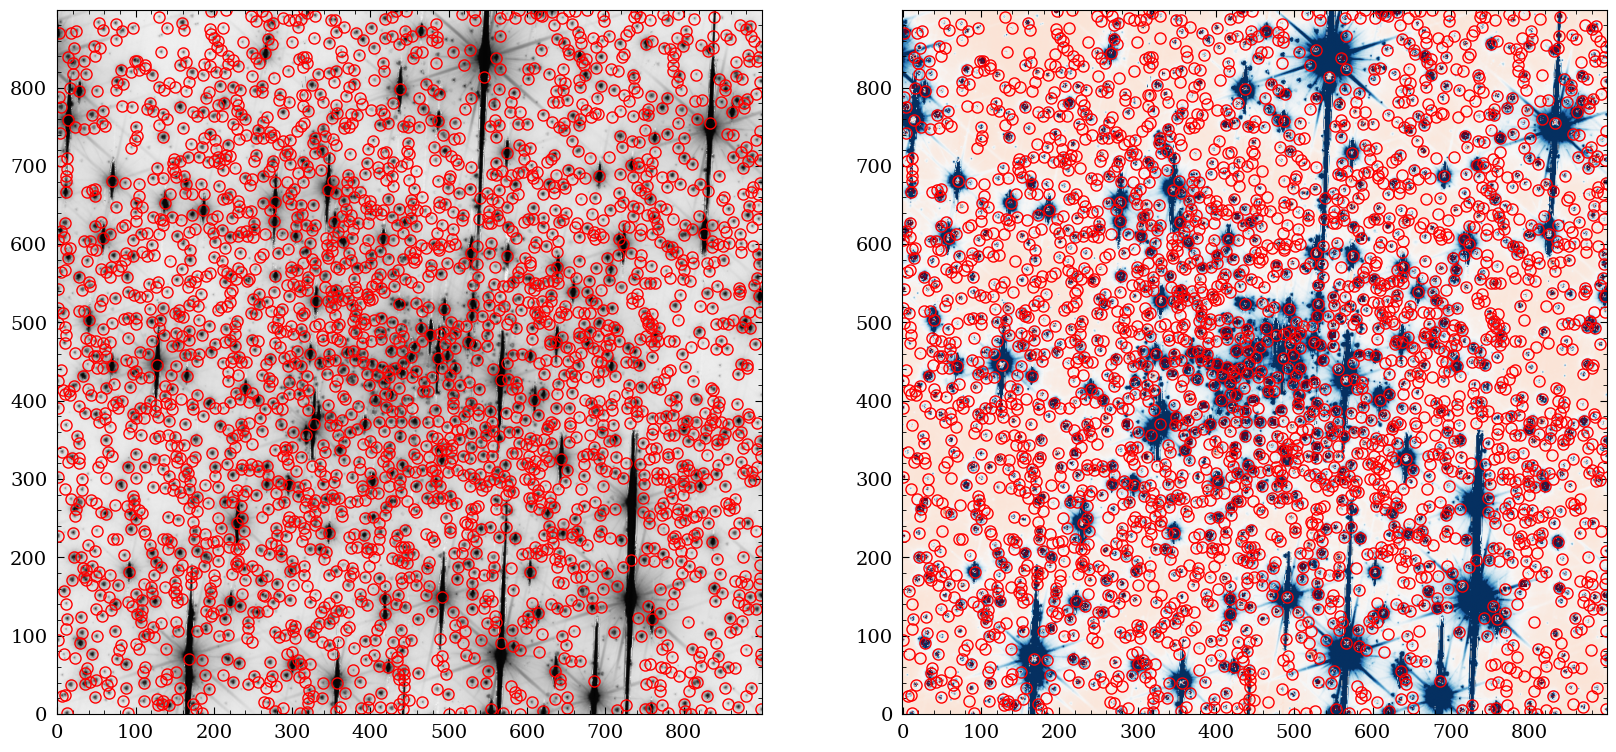

In [24]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(np.log10(img), cmap="Greys", origin="lower")
ax1.plot(phot["x_fit"], phot["y_fit"] , "o", markersize=8 , markeredgecolor="red", fillstyle="none")

ax2.imshow(resimage,vmin=-5*std, vmax=5*std, cmap="RdBu", origin="lower")
ax2.plot(phot["x_fit"], phot["y_fit"] , "o", markersize=8 , markeredgecolor="red", fillstyle="none")

plt.show()

As an additional check, we can compare the aperture photometry and the PSF photometry. We should find a good agreement between those two measurement methods. However, note that the PSF photometry should do a better job in deblending the fluxes of sources that are close by.

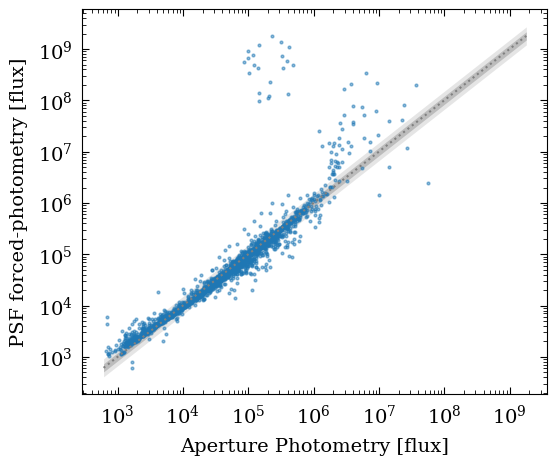

In [25]:
x = objects["flux"]
y = phot["flux_fit"]

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(x , y , "o", markersize=2, alpha=0.5)
minlim = np.nanmin(np.concatenate((x,y)))
maxlim = np.nanmax(np.concatenate((x,y)))

ax1.fill_between(np.asarray([minlim,maxlim]),np.asarray([minlim,maxlim])/1.5,np.asarray([minlim,maxlim])*1.5, color="gray", alpha=0.2, linewidth=0)
ax1.fill_between(np.asarray([minlim,maxlim]),np.asarray([minlim,maxlim])/1.2,np.asarray([minlim,maxlim])*1.2, color="gray", alpha=0.4, linewidth=0)
ax1.plot(np.asarray([minlim,maxlim]),np.asarray([minlim,maxlim]), ":", color="gray")

ax1.set_xlabel("Aperture Photometry [flux]")
ax1.set_ylabel("PSF forced-photometry [flux]")
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.show()

## Measure the Photometry on the NISP Images

We now have the photometry and the position of sources on the VIS image. We can now proceed with similar steps on the NISP images. Because the NISP PSF and pixel scale are larger that those of the VIS images, we utilize the advantage of position prior-based forced photometry.
For this, we use the positions of the VIS measurements and perform PSF fitting on the NISP image using these priors.

The steps below are almost identical to the ones applied to the VIS images.

We first isolate the data, which is in this case the NISP *H*-band filter. Note that this is an arbitrary choice and you should be encouraged to try other filters as well!

In [26]:
img2 = hdulcutout["H_SCIENCE"].data
hdr2 = hdulcutout["H_SCIENCE"].header
img2[img2 == 0] = np.nan

We again need to create a mask that will be fed to the PSF fitting module.

In [27]:
mask2 = np.isnan(img2)

... and we also get some statistics on the sky background.

In [28]:
mean2, median2, std2 = sigma_clipped_stats(img2, sigma=3.0)
print(np.array((mean2, median2, std2)))

[2626.302  1889.8518 2043.9843]


Now, we need to obtain the (x,y) image coordinates on the NISP image that correspond to the extracted sources on the VIS image. We use the WCS information from the NISP image for this case and apply it to the sky coordinates obtained on the VIS image.

In [29]:
wcs = WCS(hdr) # VIS
wcs2 = WCS(hdr2) # NISP
radec = wcs.all_pix2world(objects["x"],objects["y"], 0)
xy = wcs2.all_world2pix(radec[0],radec[1],0)

Having all this set up, we can now again perform the PSF photometry using `PSFPhotometry()` from the `photutils` package. This again can take a while, typically 1 minute.

In [30]:
psf_fwhm = 0.3 # arcsec
pixscale = 0.3 # arcsec/px

init_params = Table([xy[0],xy[1]] , names=["x","y"]) # initial positions
psf_model = CircularGaussianSigmaPRF(flux=1, sigma=psf_fwhm/pixscale / 2.35)
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
psf_model.sigma.fixed = False
fit_shape = (3, 3)
psfphot2 = PSFPhotometry(psf_model,
                        fit_shape,
                        finder = DAOStarFinder(fwhm=0.1, threshold=3.*std2, exclude_border=True), # not needed because we are using fixed initial positions.
                        aperture_radius = 4,
                        progress_bar = True)
phot2 = psfphot2(img2-median2, error=None, mask=mask2, init_params=init_params)
resimage2 = psfphot2.make_residual_image(data = img2-median2, psf_shape = (3, 3))

Add model sources: 100%|██████████| 2759/2759 [00:00<00:00, 5484.11it/s]


Fit source/group:   0%|          | 9/2759 [00:00<00:31, 88.21it/s]

Fit source/group:   1%|          | 24/2759 [00:00<00:22, 121.81it/s]

Fit source/group:   1%|▏         | 41/2759 [00:00<00:19, 137.84it/s]

Fit source/group:   2%|▏         | 55/2759 [00:00<00:21, 125.80it/s]

Fit source/group:   3%|▎         | 75/2759 [00:00<00:19, 138.81it/s]

Fit source/group:   3%|▎         | 89/2759 [00:00<00:22, 116.88it/s]

Fit source/group:   4%|▍         | 104/2759 [00:00<00:21, 123.71it/s]

Fit source/group:   4%|▍         | 117/2759 [00:00<00:22, 116.38it/s]

Fit source/group:   5%|▍         | 132/2759 [00:01<00:20, 125.26it/s]

Fit source/group:   5%|▌         | 145/2759 [00:01<00:24, 107.72it/s]

Fit source/group:   6%|▌         | 159/2759 [00:01<00:23, 108.52it/s]

Fit source/group:   6%|▌         | 171/2759 [00:01<00:25, 100.85it/s]

Fit source/group:   7%|▋         | 192/2759 [00:01<00:21, 118.87it/s]

Fit source/group:   8%|▊         | 208/2759 [00:01<00:19, 127.71it/s]

Fit source/group:   8%|▊         | 229/2759 [00:01<00:17, 141.99it/s]

Fit source/group:   9%|▉         | 244/2759 [00:01<00:17, 143.18it/s]

Fit source/group:   9%|▉         | 259/2759 [00:02<00:17, 142.95it/s]

Fit source/group:  10%|▉         | 274/2759 [00:02<00:18, 134.67it/s]

Fit source/group:  11%|█         | 290/2759 [00:02<00:17, 140.27it/s]

Fit source/group:  11%|█         | 305/2759 [00:02<00:18, 131.78it/s]

Fit source/group:  12%|█▏        | 319/2759 [00:02<00:24, 100.10it/s]

Fit source/group:  12%|█▏        | 341/2759 [00:02<00:19, 125.81it/s]

Fit source/group:  13%|█▎        | 361/2759 [00:02<00:17, 137.80it/s]

Fit source/group:  14%|█▎        | 377/2759 [00:03<00:18, 129.67it/s]

Fit source/group:  14%|█▍        | 391/2759 [00:03<00:17, 131.61it/s]

Fit source/group:  15%|█▍        | 406/2759 [00:03<00:17, 136.06it/s]

Fit source/group:  15%|█▌        | 427/2759 [00:03<00:15, 154.51it/s]

Fit source/group:  16%|█▌        | 444/2759 [00:03<00:14, 155.81it/s]

Fit source/group:  17%|█▋        | 460/2759 [00:03<00:16, 142.81it/s]

Fit source/group:  17%|█▋        | 475/2759 [00:03<00:17, 132.61it/s]

Fit source/group:  18%|█▊        | 495/2759 [00:03<00:15, 149.90it/s]

Fit source/group:  19%|█▊        | 511/2759 [00:03<00:16, 136.82it/s]

Fit source/group:  19%|█▉        | 528/2759 [00:04<00:15, 141.88it/s]

Fit source/group:  20%|█▉        | 543/2759 [00:04<00:18, 121.37it/s]

Fit source/group:  20%|██        | 558/2759 [00:04<00:17, 127.19it/s]

Fit source/group:  21%|██        | 572/2759 [00:04<00:17, 121.51it/s]

Fit source/group:  21%|██        | 585/2759 [00:04<00:18, 115.86it/s]

Fit source/group:  22%|██▏       | 600/2759 [00:04<00:18, 114.04it/s]

Fit source/group:  22%|██▏       | 612/2759 [00:04<00:23, 93.19it/s] 

Fit source/group:  23%|██▎       | 634/2759 [00:05<00:18, 112.28it/s]

Fit source/group:  24%|██▍       | 658/2759 [00:05<00:16, 131.05it/s]

Fit source/group:  24%|██▍       | 674/2759 [00:05<00:15, 137.31it/s]

Fit source/group:  25%|██▍       | 689/2759 [00:05<00:16, 128.10it/s]

Fit source/group:  25%|██▌       | 703/2759 [00:05<00:19, 106.85it/s]

Fit source/group:  26%|██▌       | 715/2759 [00:05<00:19, 105.24it/s]

Fit source/group:  26%|██▋       | 727/2759 [00:05<00:19, 104.48it/s]

Fit source/group:  27%|██▋       | 746/2759 [00:05<00:16, 121.71it/s]

Fit source/group:  28%|██▊       | 759/2759 [00:06<00:18, 107.73it/s]

Fit source/group:  28%|██▊       | 778/2759 [00:06<00:16, 122.77it/s]

Fit source/group:  29%|██▉       | 796/2759 [00:06<00:15, 128.86it/s]

Fit source/group:  30%|██▉       | 818/2759 [00:06<00:13, 138.69it/s]

Fit source/group:  30%|███       | 833/2759 [00:06<00:14, 129.14it/s]

Fit source/group:  31%|███       | 849/2759 [00:06<00:15, 125.68it/s]

Fit source/group:  31%|███▏      | 865/2759 [00:06<00:14, 132.85it/s]

Fit source/group:  32%|███▏      | 879/2759 [00:06<00:14, 126.95it/s]

Fit source/group:  32%|███▏      | 894/2759 [00:07<00:14, 132.29it/s]

Fit source/group:  33%|███▎      | 910/2759 [00:07<00:14, 128.17it/s]

Fit source/group:  34%|███▎      | 926/2759 [00:07<00:13, 135.09it/s]

Fit source/group:  34%|███▍      | 945/2759 [00:07<00:12, 143.06it/s]

Fit source/group:  35%|███▍      | 960/2759 [00:07<00:13, 132.81it/s]

Fit source/group:  35%|███▌      | 974/2759 [00:07<00:14, 120.79it/s]

Fit source/group:  36%|███▌      | 987/2759 [00:07<00:16, 106.69it/s]

Fit source/group:  36%|███▌      | 999/2759 [00:08<00:17, 100.25it/s]

Fit source/group:  37%|███▋      | 1021/2759 [00:08<00:13, 128.00it/s]

Fit source/group:  38%|███▊      | 1038/2759 [00:08<00:12, 136.48it/s]

Fit source/group:  38%|███▊      | 1053/2759 [00:08<00:14, 117.21it/s]

Fit source/group:  39%|███▉      | 1072/2759 [00:08<00:13, 127.38it/s]

Fit source/group:  39%|███▉      | 1088/2759 [00:08<00:13, 124.28it/s]

Fit source/group:  40%|████      | 1109/2759 [00:08<00:12, 135.82it/s]

Fit source/group:  41%|████      | 1123/2759 [00:08<00:13, 125.55it/s]

Fit source/group:  41%|████      | 1136/2759 [00:09<00:13, 120.17it/s]

Fit source/group:  42%|████▏     | 1149/2759 [00:09<00:14, 107.91it/s]

Fit source/group:  42%|████▏     | 1165/2759 [00:09<00:13, 119.31it/s]

Fit source/group:  43%|████▎     | 1183/2759 [00:09<00:12, 130.58it/s]

Fit source/group:  43%|████▎     | 1197/2759 [00:09<00:12, 128.20it/s]

Fit source/group:  44%|████▍     | 1211/2759 [00:09<00:13, 111.51it/s]

Fit source/group:  44%|████▍     | 1223/2759 [00:09<00:14, 108.22it/s]

Fit source/group:  45%|████▍     | 1235/2759 [00:09<00:14, 105.93it/s]

Fit source/group:  45%|████▌     | 1246/2759 [00:10<00:14, 101.75it/s]

Fit source/group:  46%|████▌     | 1267/2759 [00:10<00:11, 129.25it/s]

Fit source/group:  47%|████▋     | 1285/2759 [00:10<00:10, 139.65it/s]

Fit source/group:  47%|████▋     | 1300/2759 [00:10<00:10, 141.79it/s]

Fit source/group:  48%|████▊     | 1315/2759 [00:10<00:11, 127.21it/s]

Fit source/group:  48%|████▊     | 1329/2759 [00:10<00:17, 83.46it/s] 

Fit source/group:  49%|████▊     | 1340/2759 [00:10<00:16, 86.00it/s]

Fit source/group:  49%|████▉     | 1351/2759 [00:11<00:15, 88.74it/s]

Fit source/group:  49%|████▉     | 1364/2759 [00:11<00:15, 91.01it/s]

Fit source/group:  50%|████▉     | 1375/2759 [00:11<00:15, 88.72it/s]

Fit source/group:  50%|█████     | 1385/2759 [00:11<00:15, 88.10it/s]

Fit source/group:  51%|█████     | 1395/2759 [00:11<00:15, 88.79it/s]

Fit source/group:  51%|█████     | 1408/2759 [00:11<00:14, 91.22it/s]

Fit source/group:  51%|█████▏    | 1418/2759 [00:11<00:14, 90.53it/s]

Fit source/group:  52%|█████▏    | 1441/2759 [00:11<00:10, 125.90it/s]

Fit source/group:  53%|█████▎    | 1456/2759 [00:12<00:09, 131.08it/s]

Fit source/group:  54%|█████▎    | 1481/2759 [00:12<00:07, 161.90it/s]

Fit source/group:  54%|█████▍    | 1499/2759 [00:12<00:07, 165.64it/s]

Fit source/group:  55%|█████▍    | 1516/2759 [00:12<00:08, 145.21it/s]

Fit source/group:  56%|█████▌    | 1532/2759 [00:12<00:10, 117.42it/s]

Fit source/group:  56%|█████▌    | 1548/2759 [00:12<00:10, 117.69it/s]

Fit source/group:  57%|█████▋    | 1565/2759 [00:12<00:09, 126.82it/s]

Fit source/group:  57%|█████▋    | 1579/2759 [00:12<00:09, 128.66it/s]

Fit source/group:  58%|█████▊    | 1601/2759 [00:13<00:07, 150.70it/s]

Fit source/group:  59%|█████▊    | 1617/2759 [00:13<00:09, 119.59it/s]

Fit source/group:  59%|█████▉    | 1631/2759 [00:13<00:09, 122.43it/s]

Fit source/group:  60%|█████▉    | 1645/2759 [00:13<00:10, 106.85it/s]

Fit source/group:  60%|██████    | 1659/2759 [00:13<00:09, 113.75it/s]

Fit source/group:  61%|██████    | 1672/2759 [00:13<00:09, 111.56it/s]

Fit source/group:  61%|██████    | 1686/2759 [00:13<00:09, 117.49it/s]

Fit source/group:  62%|██████▏   | 1700/2759 [00:13<00:08, 123.32it/s]

Fit source/group:  62%|██████▏   | 1714/2759 [00:14<00:08, 127.79it/s]

Fit source/group:  63%|██████▎   | 1728/2759 [00:14<00:08, 122.30it/s]

Fit source/group:  63%|██████▎   | 1741/2759 [00:14<00:08, 114.22it/s]

Fit source/group:  64%|██████▎   | 1753/2759 [00:14<00:09, 110.88it/s]

Fit source/group:  64%|██████▍   | 1765/2759 [00:14<00:09, 106.18it/s]

Fit source/group:  64%|██████▍   | 1776/2759 [00:14<00:09, 103.04it/s]

Fit source/group:  65%|██████▍   | 1787/2759 [00:14<00:10, 91.66it/s] 

Fit source/group:  65%|██████▌   | 1802/2759 [00:14<00:09, 105.74it/s]

Fit source/group:  66%|██████▌   | 1819/2759 [00:15<00:07, 121.76it/s]

Fit source/group:  66%|██████▋   | 1832/2759 [00:15<00:07, 116.54it/s]

Fit source/group:  67%|██████▋   | 1847/2759 [00:15<00:07, 125.29it/s]

Fit source/group:  67%|██████▋   | 1860/2759 [00:15<00:07, 118.31it/s]

Fit source/group:  68%|██████▊   | 1873/2759 [00:15<00:08, 103.45it/s]

Fit source/group:  69%|██████▊   | 1892/2759 [00:15<00:07, 121.00it/s]

Fit source/group:  69%|██████▉   | 1907/2759 [00:15<00:06, 125.21it/s]

Fit source/group:  70%|██████▉   | 1920/2759 [00:15<00:07, 111.44it/s]

Fit source/group:  70%|███████   | 1934/2759 [00:16<00:06, 118.22it/s]

Fit source/group:  71%|███████   | 1947/2759 [00:16<00:07, 106.62it/s]

Fit source/group:  71%|███████   | 1959/2759 [00:16<00:07, 104.83it/s]

Fit source/group:  72%|███████▏  | 1975/2759 [00:16<00:06, 116.59it/s]

Fit source/group:  72%|███████▏  | 1988/2759 [00:16<00:07, 104.98it/s]

Fit source/group:  72%|███████▏  | 1999/2759 [00:16<00:07, 101.36it/s]

Fit source/group:  73%|███████▎  | 2013/2759 [00:16<00:06, 109.85it/s]

Fit source/group:  73%|███████▎  | 2025/2759 [00:16<00:07, 102.98it/s]

Fit source/group:  74%|███████▍  | 2042/2759 [00:17<00:05, 119.66it/s]

Fit source/group:  74%|███████▍  | 2055/2759 [00:17<00:06, 112.41it/s]

Fit source/group:  75%|███████▌  | 2074/2759 [00:17<00:05, 120.79it/s]

Fit source/group:  76%|███████▌  | 2087/2759 [00:17<00:05, 116.40it/s]

Fit source/group:  76%|███████▌  | 2099/2759 [00:17<00:05, 111.38it/s]

Fit source/group:  77%|███████▋  | 2117/2759 [00:17<00:05, 125.85it/s]

Fit source/group:  77%|███████▋  | 2133/2759 [00:17<00:04, 134.57it/s]

Fit source/group:  78%|███████▊  | 2147/2759 [00:17<00:04, 125.39it/s]

Fit source/group:  78%|███████▊  | 2160/2759 [00:17<00:05, 119.35it/s]

Fit source/group:  79%|███████▉  | 2173/2759 [00:18<00:05, 117.05it/s]

Fit source/group:  79%|███████▉  | 2186/2759 [00:18<00:04, 120.46it/s]

Fit source/group:  80%|███████▉  | 2201/2759 [00:18<00:04, 128.44it/s]

Fit source/group:  80%|████████  | 2215/2759 [00:18<00:04, 110.76it/s]

Fit source/group:  81%|████████  | 2229/2759 [00:18<00:04, 117.18it/s]

Fit source/group:  81%|████████▏ | 2242/2759 [00:18<00:04, 104.78it/s]

Fit source/group:  82%|████████▏ | 2257/2759 [00:18<00:04, 115.80it/s]

Fit source/group:  82%|████████▏ | 2270/2759 [00:18<00:04, 116.83it/s]

Fit source/group:  83%|████████▎ | 2283/2759 [00:19<00:04, 114.70it/s]

Fit source/group:  83%|████████▎ | 2299/2759 [00:19<00:03, 125.65it/s]

Fit source/group:  84%|████████▍ | 2319/2759 [00:19<00:03, 145.22it/s]

Fit source/group:  85%|████████▍ | 2334/2759 [00:19<00:03, 140.96it/s]

Fit source/group:  85%|████████▌ | 2349/2759 [00:19<00:03, 120.74it/s]

Fit source/group:  86%|████████▌ | 2362/2759 [00:19<00:03, 106.08it/s]

Fit source/group:  86%|████████▌ | 2374/2759 [00:19<00:03, 96.78it/s] 

Fit source/group:  86%|████████▋ | 2385/2759 [00:19<00:03, 96.12it/s]

Fit source/group:  87%|████████▋ | 2397/2759 [00:20<00:03, 97.64it/s]

Fit source/group:  87%|████████▋ | 2412/2759 [00:20<00:03, 108.90it/s]

Fit source/group:  88%|████████▊ | 2428/2759 [00:20<00:02, 113.64it/s]

Fit source/group:  88%|████████▊ | 2440/2759 [00:20<00:02, 106.44it/s]

Fit source/group:  89%|████████▉ | 2452/2759 [00:20<00:02, 103.69it/s]

Fit source/group:  89%|████████▉ | 2463/2759 [00:20<00:02, 100.56it/s]

Fit source/group:  90%|████████▉ | 2474/2759 [00:20<00:02, 102.24it/s]

Fit source/group:  90%|█████████ | 2486/2759 [00:20<00:02, 101.15it/s]

Fit source/group:  91%|█████████ | 2497/2759 [00:21<00:02, 90.90it/s] 

Fit source/group:  91%|█████████▏| 2518/2759 [00:21<00:02, 112.75it/s]

Fit source/group:  92%|█████████▏| 2530/2759 [00:21<00:02, 95.38it/s] 

Fit source/group:  92%|█████████▏| 2540/2759 [00:21<00:02, 92.95it/s]

Fit source/group:  93%|█████████▎| 2555/2759 [00:21<00:01, 106.59it/s]

Fit source/group:  93%|█████████▎| 2569/2759 [00:21<00:01, 108.43it/s]

Fit source/group:  94%|█████████▍| 2590/2759 [00:21<00:01, 124.95it/s]

Fit source/group:  95%|█████████▍| 2614/2759 [00:22<00:01, 141.02it/s]

Fit source/group:  96%|█████████▌| 2635/2759 [00:22<00:00, 158.12it/s]

Fit source/group:  96%|█████████▌| 2652/2759 [00:22<00:00, 154.93it/s]

Fit source/group:  97%|█████████▋| 2668/2759 [00:22<00:00, 154.88it/s]

Fit source/group:  97%|█████████▋| 2687/2759 [00:22<00:00, 158.30it/s]

Fit source/group:  98%|█████████▊| 2708/2759 [00:22<00:00, 161.38it/s]

Fit source/group:  99%|█████████▉| 2725/2759 [00:22<00:00, 117.55it/s]

Fit source/group:  99%|█████████▉| 2739/2759 [00:22<00:00, 121.94it/s]

Fit source/group: 100%|██████████| 2759/2759 [00:23<00:00, 119.90it/s]

Add model sources:   0%|          | 0/2759 [00:00<?, ?it/s]

Add model sources:  20%|█▉        | 549/2759 [00:00<00:00, 5489.84it/s]

Add model sources:  40%|████      | 1115/2759 [00:00<00:00, 5588.12it/s]

Add model sources:  61%|██████    | 1683/2759 [00:00<00:00, 5625.90it/s]

Add model sources:  81%|████████▏ | 2246/2759 [00:00<00:00, 5379.69it/s]

Add model sources: 100%|██████████| 2759/2759 [00:00<00:00, 5484.11it/s]

Again, we convert the pixel coordinates to sky coordinates and add them to the catalog.

In [31]:
wcs2 = WCS(hdr2) # NISP
radec = wcs2.all_pix2world(phot2["x_fit"],phot2["y_fit"],0)
phot2["ra_fit"] = radec[0]
phot2["dec_fit"] = radec[1]

Finally, we create the same figure as above, showing the NISP image and the residual with the (VIS-extracted) sources overlaid.

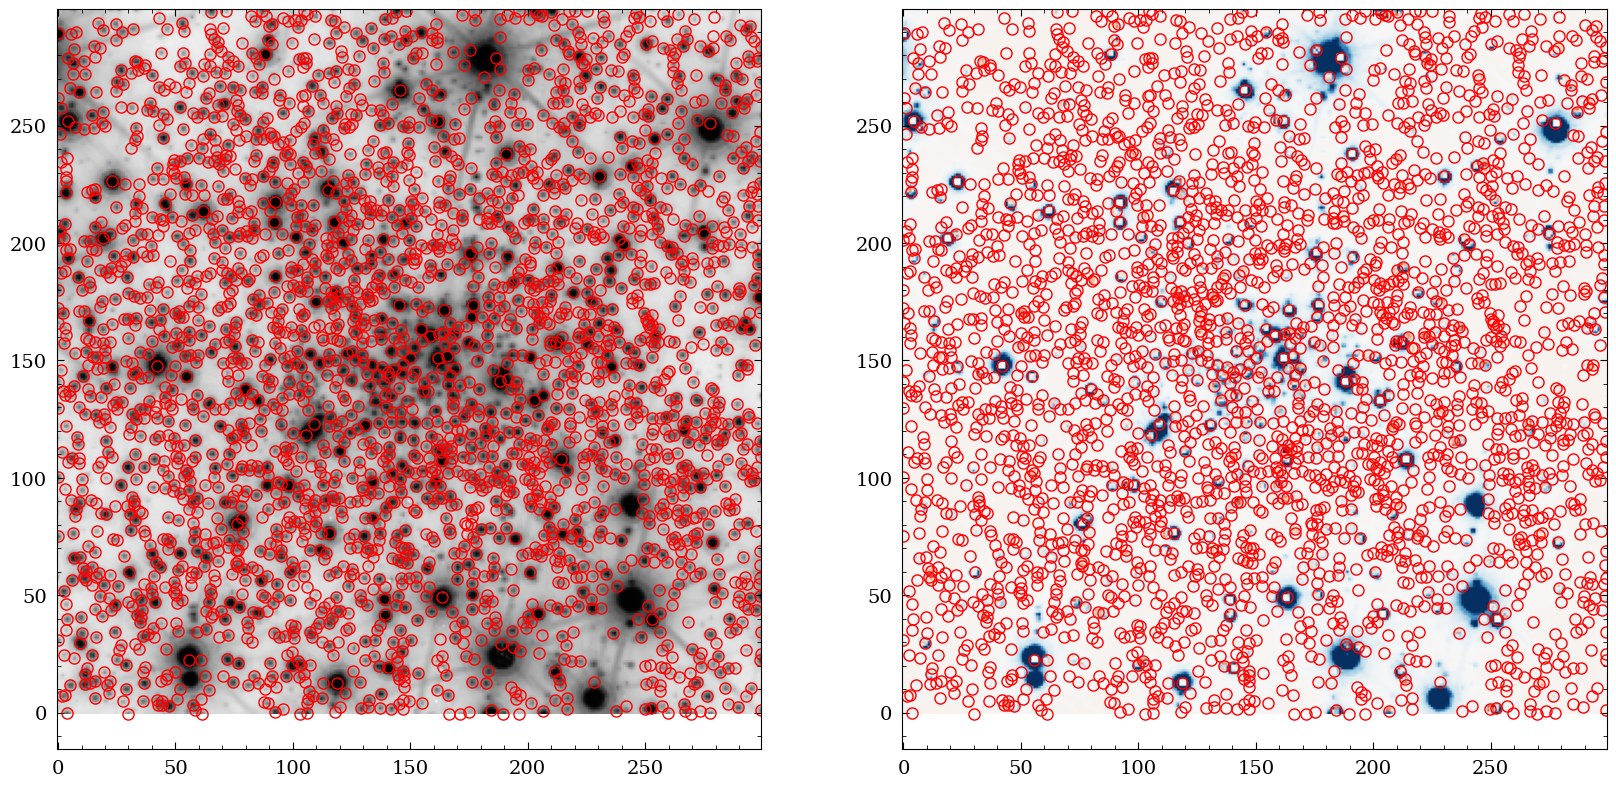

In [32]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(np.log10(img2), cmap="Greys", origin="lower")
ax1.plot(phot2["x_fit"], phot2["y_fit"] , "o", markersize=8 , markeredgecolor="red", fillstyle="none")

ax2.imshow(resimage2,vmin=-20*std2, vmax=20*std2, cmap="RdBu", origin="lower")
ax2.plot(phot2["x_fit"], phot2["y_fit"] , "o", markersize=8 , markeredgecolor="red", fillstyle="none")

plt.show()

## Load Gaia Catalog

We now load the Gaia sources at the location of the globular clusters. The goal is to compare the photometry of Gaia to the one derived above for the Euclid VIS and NISP images. This is scientifically useful, for example we can compute the colors of the stars in the Gaia optical bands and the Euclid near-IR bands.
To search for Gaia sources, we use `astroquery` again.

We first have to elimiate the row limit for the Gaia query by setting

In [33]:
Gaia.ROW_LIMIT = -1

Next, we request the Gaia catalog around the position of the globular cluster. We use the same size as the cutout size.

In [34]:
gaia_objects = Gaia.query_object_async(coordinate=coord, radius = cutout_size/2)
print("Number of Gaia stars found: {}".format(len(gaia_objects)))

INFO: Query finished. [astroquery.utils.tap.core]
Number of Gaia stars found: 1202


We then convert the sky coordinates of the Gaia stars to (x,y) image coordinates for VIS and NISP images using the corresponding WCS. This makes it more easy to plot the Gaia sources later on the images.

In [35]:
wcs = WCS(hdr) # VIS
wcs2 = WCS(hdr2) # NISP
xy = wcs.all_world2pix(gaia_objects["ra"],gaia_objects["dec"],0)
xy2 = wcs2.all_world2pix(gaia_objects["ra"],gaia_objects["dec"],0)

gaia_objects["x_vis"] = xy[0]
gaia_objects["y_vis"] = xy[1]
gaia_objects["x_nisp"] = xy2[0]
gaia_objects["y_nisp"] = xy2[1]

We save the Gaia table to disk as we will later use it for the visualization in `Firefly`.

In [36]:
gaia_objects.write("./data/gaiatable.csv", format="csv", overwrite=True)

Now we can overlay the Gaia sources on the VIS and NISP images (here the x/y coordinates become handy).

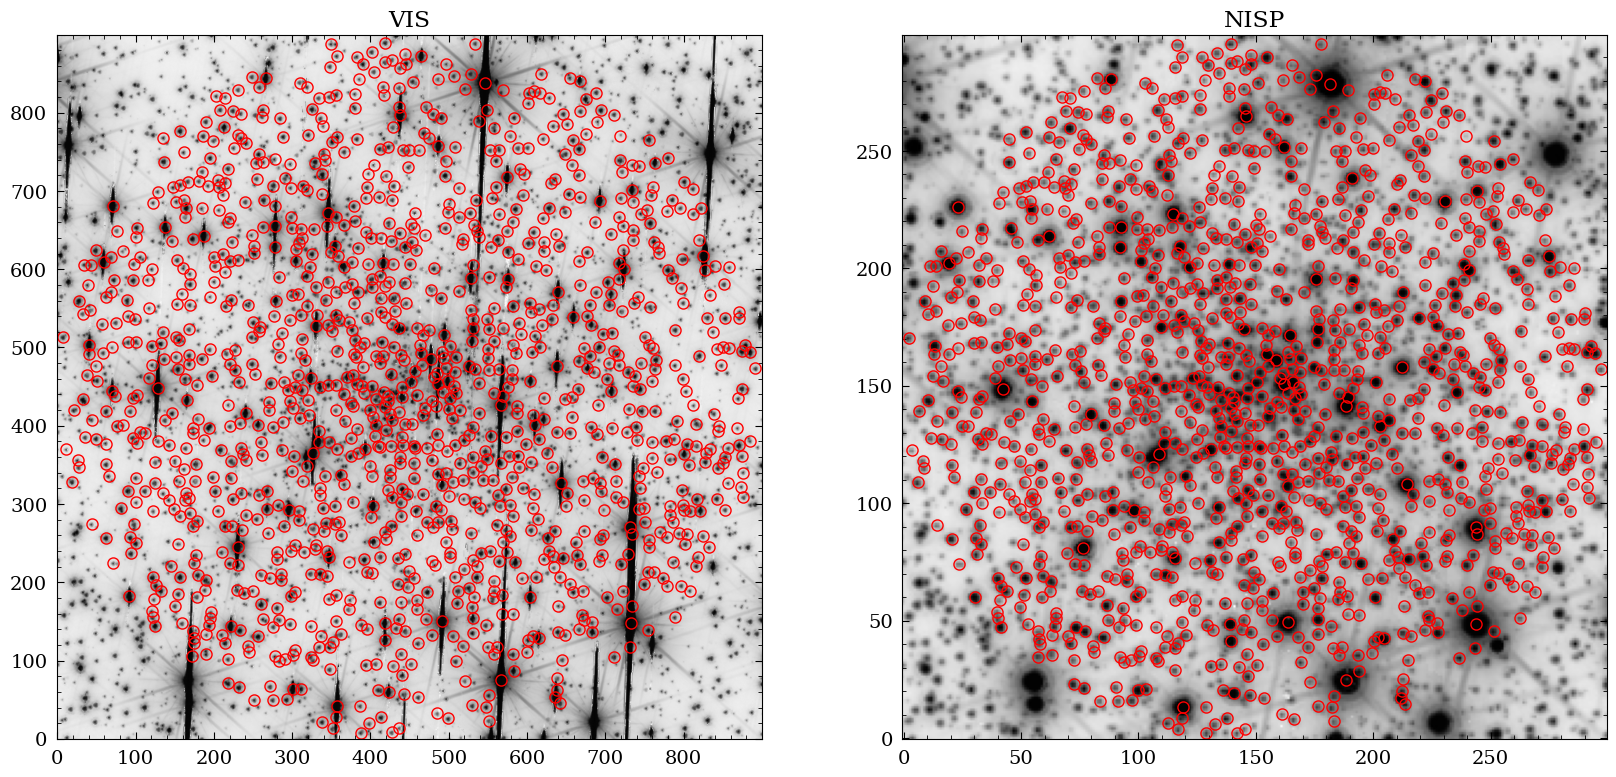

In [37]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(np.log10(img), cmap="Greys", origin="lower")
ax1.plot(gaia_objects["x_vis"], gaia_objects["y_vis"] , "o", markersize=8 , markeredgecolor="red", fillstyle="none")
ax1.set_title("VIS")

ax2.imshow(np.log10(img2), cmap="Greys", origin="lower")
ax2.plot(gaia_objects["x_nisp"], gaia_objects["y_nisp"] , "o", markersize=8 , markeredgecolor="red", fillstyle="none")
ax2.set_title("NISP")

plt.show()

## Match the Gaia Catalog to the VIS and NISP Catalogs

Now, we match the Gaia source positions to the extracted sources in the VIS and NISP images.

We first define which Gaia columns to copy to the matched catalog as well as the matching distance.

In [38]:
gaia_keys = ["source_id", "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag","ra","dec","pmra","pmdec"]
matching_distance = 0.6*u.arcsecond

First match to the VIS image. We use the `astropy` *SkyCoord()* function for matching in sky coordinates.

In [39]:
c = SkyCoord(ra=phot["ra_fit"]*u.degree, dec=phot["dec_fit"]*u.degree )
catalog = SkyCoord(ra=gaia_objects["ra"].data*u.degree, dec=gaia_objects["dec"].data*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

sel_matched = np.where(d2d.to(u.arcsecond) < (matching_distance))[0]
print("Gaia Sources matched to VIS: {}".format( len(sel_matched) ) )
phot["gaia_distance"] = d2d.to(u.arcsecond)

for gaia_key in gaia_keys:
    phot["gaia_{}".format(gaia_key)] = 0.0
    phot["gaia_{}".format(gaia_key)][sel_matched] = gaia_objects[gaia_key][idx[sel_matched]]

Gaia Sources matched to VIS: 1223


And then we add the NISP sources. Note that we do not have to perform matching here because by design the VIS and NISP sources are matched (spatial prior forced photometry).

In [40]:
phot2["gaia_distance"] = d2d.to(u.arcsecond)

for gaia_key in gaia_keys:
    phot2["gaia_{}".format(gaia_key)] = 0.0
    phot2["gaia_{}".format(gaia_key)][sel_matched] = gaia_objects[gaia_key][idx[sel_matched]]

Once matched, we can now compare the Gaia and Euclid/NISP magnitudes of the stars.

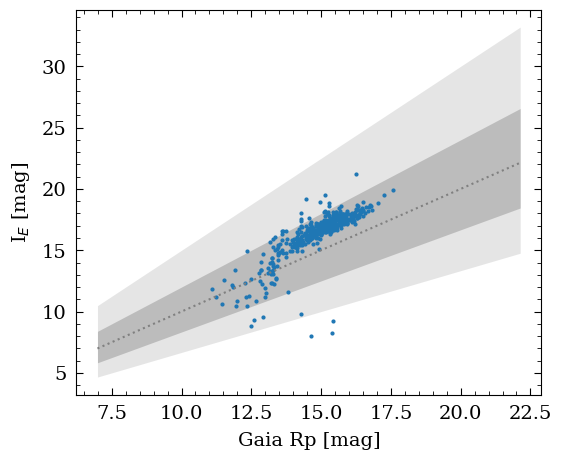

In [41]:
# Data
x = phot["gaia_phot_rp_mean_mag"]
y = -2.5*np.log10(phot["flux_fit"]) + hdr["ZP_STACK"]

# selection
sel_good = np.where(phot["gaia_source_id"] > 0)[0]
x = x[sel_good]
y = y[sel_good]

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(x , y , "o", markersize=2)
minlim = np.nanmin(np.concatenate((x,y)))
maxlim = np.nanmax(np.concatenate((x,y)))

ax1.fill_between(np.asarray([minlim,maxlim]),np.asarray([minlim,maxlim])/1.5,np.asarray([minlim,maxlim])*1.5, color="gray", alpha=0.2, linewidth=0)
ax1.fill_between(np.asarray([minlim,maxlim]),np.asarray([minlim,maxlim])/1.2,np.asarray([minlim,maxlim])*1.2, color="gray", alpha=0.4, linewidth=0)
ax1.plot(np.asarray([minlim,maxlim]),np.asarray([minlim,maxlim]), ":", color="gray")

ax1.set_xlabel("Gaia Rp [mag]")
ax1.set_ylabel("I$_E$ [mag]")
plt.show()

## Visualization with Firefly

At the end of this Notebook, we demonstrate how we can visualize the images and catalogs created above in `Firefly`.

We start by initializing the Firefly client.
The following line will open a new `Firefly` GUI in a separate tab **inside** the Jupyter Notebook environment. The user can drag the tab onto the currently open tab to create a "split tab". This the user to see the code and images side-by-side.

In [42]:
# Uncomment when using within Jupyter Lab with jupyter_firefly_extensions installed
# fc = FireflyClient.make_lab_client()

# Uncomment for contexts other than the above
fc = FireflyClient.make_client(url="https://irsa.ipac.caltech.edu/irsaviewer")

In order to display in image or catalog in `Firefly`, it needs to be uploaded to the `Firefly` server. We do this here using the `upload_file()` function.
We first upload the FITS image that we created above.

In [43]:
fval = fc.upload_file('./data/euclid_images_test.fits')

Once the image is uploaded we can use the `show_fits()` function to display it.
Note that our FITS image has multiple extensions (VIS, and NISP bands). We can open them separately in new `Firefly` tabs by looping over the HDUs and specifying the plot ID by the extension's name.

In [44]:
for hh,hdu in enumerate(hdulcutout):
    fc.show_fits(fval, MultiImageIdx=hh, plot_id=hdu.header["EXTNAME"] )

We can lock the WCS between the images (allowing the user to pan and zoom the images simultaneously) by running:

In [45]:
fc.align_images(lock_match=True)

{'success': True}

In the same way, we can upload a table, in this case our Gaia table. We again use `upload_file()` but in this case we use `show_table()` to show it in `Firefly`.

In [46]:
tval = fc.upload_file('./data/gaiatable.csv')
fc.show_table(tval, tbl_id = "gaiatable")

{'success': True}

Now, check out the `Firefly` GUI. You can zoom the images, click on sources, filter the table, display different selection, and much more!

***

## About this Notebook

**Author**: Andreas Faisst (IPAC Scientist)

**Updated**: 2025-03-17

**Contact**: the [IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.